In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from joblib import Parallel, delayed
from sklearn.linear_model import Lasso
import pickle
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
# Dataset path
dataset_path = 'datasets/pancreas_dev.h5ad'

# Load dataset
if os.path.exists(dataset_path):
    print("File exists. Loading the dataset...")
    adata = sc.read_h5ad(dataset_path)
    print("Dataset loaded successfully!")
    print("Dataset shape:", adata.shape)
else:
    print("File does not exist at the specified path:", dataset_path)

File exists. Loading the dataset...
Dataset loaded successfully!
Dataset shape: (5454, 15010)


/home/kamdar.jh/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
# Step 1: Normalize total counts to 1e4 (standard step)
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Log transformation
sc.pp.log1p(adata)

# Step 3: Scale the data to the 0-1 range using MinMaxScaler
scaler = MinMaxScaler()
adata.X = scaler.fit_transform(adata.X.toarray())

# Step 4: Identify the top 1000 highly variable genes (HVGs)
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')

# Step 5: Subset the dataset to only include these HVGs
adata = adata[:, adata.var['highly_variable']].copy()

print(f"Dataset shape after selecting top 1000 HVGs: {adata.shape}")


Dataset shape after selecting top 1000 HVGs: (5454, 1000)


/home/kamdar.jh/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/kamdar.jh/.conda/envs/Capstone/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-20 13:56:29.111801: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 13:56:29.158575: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 13:56:29.159622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 13:56:31.856075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kamdar.jh/.local

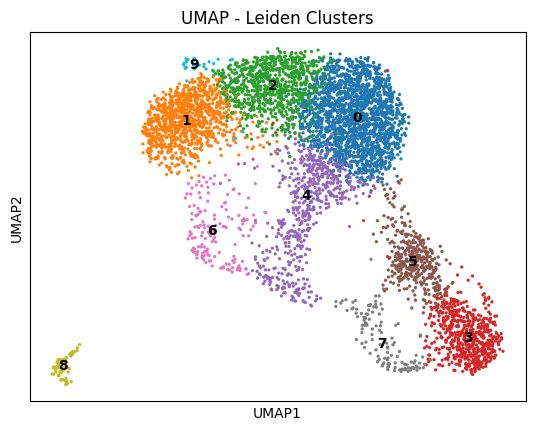

In [4]:
# Step 1: PCA for dimensionality reduction
sc.pp.pca(adata)

# Step 2: Compute nearest neighbors
sc.pp.neighbors(adata)

# Step 3: Run UMAP for visualization
sc.tl.umap(adata)

# Step 4: Apply Leiden clustering with a resolution of 0.5 
sc.tl.leiden(adata, resolution=1, key_added="leiden")

sc.pl.umap(adata, color="leiden", legend_loc="on data", title="UMAP - Leiden Clusters")


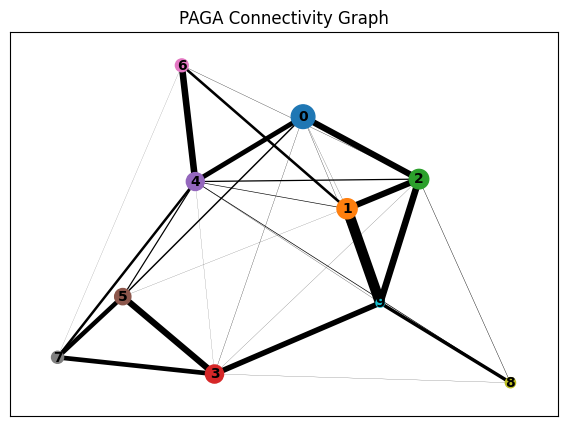

/home/kamdar.jh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


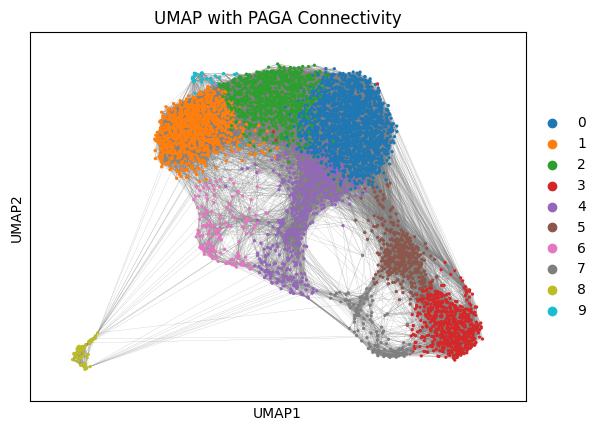

In [5]:
# Step 1: Compute PAGA
sc.tl.paga(adata, groups='leiden')

# Step 2: Visualize the PAGA Graph on the UMAP
sc.pl.paga(adata, color='leiden', title="PAGA Connectivity Graph")

# Optional: Also overlay PAGA on UMAP for better clarity
sc.pl.umap(adata, color=['leiden'], edges=True, title="UMAP with PAGA Connectivity")


In [6]:
# Extract PAGA connectivity graph
conn = adata.uns['paga']['connectivities']

# Convert to dense format if needed
conn_dense = conn.todense() if hasattr(conn, "todense") else np.array(conn)

# Extract unique clusters and sort them
clusters = sorted(adata.obs['leiden'].unique(), key=lambda x: int(x))

# Compute average 'days_num' for each cluster
avg_time = {
    cl: np.mean(adata.obs.loc[adata.obs['leiden'] == cl, 'days_num'].astype(float))
    for cl in clusters
}

print("Average time per cluster:", avg_time)


Average time per cluster: {'0': 13.269535673839185, '1': 15.393776824034335, '2': 13.954212454212454, '3': 14.709225700164744, '4': 13.356401384083044, '5': 14.502564102564103, '6': 14.57843137254902, '7': 14.626050420168067, '8': 13.565573770491802, '9': 15.258620689655173}


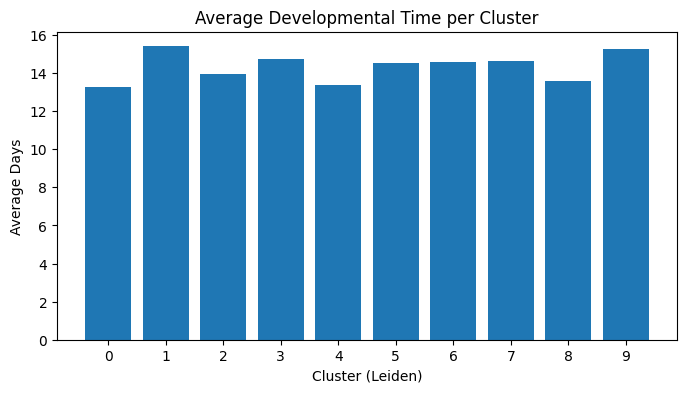

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(len(clusters)), [avg_time[cl] for cl in clusters], tick_label=clusters)
plt.xlabel("Cluster (Leiden)")
plt.ylabel("Average Days")
plt.title("Average Developmental Time per Cluster")
plt.show()


In [8]:
DG = nx.DiGraph()
root = min(avg_time, key=avg_time.get)
for cl in clusters:
    DG.add_node(cl, avg_time=avg_time[cl])
for i, cl1 in enumerate(clusters):
    for j, cl2 in enumerate(clusters):
        if conn_dense[i, j] > 0:
            if avg_time[cl1] < avg_time[cl2]:
                DG.add_edge(cl1, cl2, weight=conn_dense[i, j])
            else:
                DG.add_edge(cl2, cl1, weight=conn_dense[i, j])


In [9]:
# === Validate DAG ===
if nx.is_directed_acyclic_graph(DG):
    print("The structure is a valid DAG.")
else:
    print("Cycle detected in the graph. Please fix the structure.")

The structure is a valid DAG.


In [10]:
# === Create Parent and Children Maps ===
parent_map = {}
children_map = {cl: [] for cl in clusters}
for node in DG.nodes():
    if node == root:
        parent_map[node] = None
        continue
    in_edges = list(DG.in_edges(node, data=True))
    if in_edges:
        parent, _, _ = max(in_edges, key=lambda e: e[2]['weight'])
        parent_map[node] = parent
        children_map[parent].append(node)

# === Build Structure List ===
structure_nodes = {}
global_state_counter = 0
queue = deque([root])
structure_nodes[root] = {
    'ID': int(root),
    'Sp_idx': global_state_counter,
    'Sc_idx': global_state_counter + 1,
    'level': 0,
    'alpha': np.zeros(adata.n_vars),
    'child_path': [],
    'parent_path': []
}
global_state_counter += 2

visited = set([root])
while queue:
    current = queue.popleft()
    current_node = structure_nodes[current]
    for child in children_map.get(current, []):
        if child not in visited:
            queue.append(child)
            visited.add(child)
            structure_nodes[child] = {
                'ID': int(child),
                'Sp_idx': current_node['Sc_idx'],
                'Sc_idx': current_node['Sc_idx'] + 1,
                'level': current_node['level'] + 1,
                'alpha': np.mean(adata[adata.obs['leiden'] == child].X, axis=0),
                'child_path': [],
                'parent_path': [current_node['ID']]
            }
            global_state_counter += 2
        else:
            if current_node['ID'] not in structure_nodes[child]['parent_path']:
                structure_nodes[child]['parent_path'].append(current_node['ID'])
        current_node['child_path'].append(int(child))

structure_list = list(structure_nodes.values())

# === Save Structure List ===
with open('structure_list.pkl', 'wb') as f:
    pickle.dump(structure_list, f)
print("Structure list saved successfully.")

Structure list saved successfully.


In [11]:
from collections import deque
import numpy as np

# Initialize structure nodes and global counter for indexing
structure_nodes = {}
global_state_counter = 0
queue = deque([root])

# Initialize root node
structure_nodes[root] = {
    'ID': int(root),
    'Sp_idx': global_state_counter,
    'Sc_idx': global_state_counter + 1,
    'level': 0,
    'alpha': np.zeros(adata.n_vars),
    'child_path': [],
    'parent_path': []  # Allow multiple parents
}
global_state_counter += 2
visited = set([root])

while queue:
    current = queue.popleft()
    current_node = structure_nodes[current]

    # Process each child of the current node
    for child in children_map.get(current, []):
        if child not in visited:
            queue.append(child)
            visited.add(child)

            # Create or update the child node structure
            structure_nodes[child] = {
                'ID': int(child),
                'Sp_idx': current_node['Sc_idx'],
                'Sc_idx': current_node['Sc_idx'] + 1,
                'level': current_node['level'] + 1,
                'alpha': np.zeros(adata.n_vars),
                'child_path': [],
                'parent_path': [current_node['ID']]  # Add current parent
            }
            global_state_counter += 2
        else:
            # If already visited, append the additional parent
            if current_node['ID'] not in structure_nodes[child]['parent_path']:
                structure_nodes[child]['parent_path'].append(current_node['ID'])

        # Update current node's child path to ensure branching is captured
        if int(child) not in current_node['child_path']:
            current_node['child_path'].append(int(child))

# === Fix: Ensure All Nodes Are Included ===
for node in DG.nodes():
    if node not in structure_nodes:
        structure_nodes[node] = {
            'ID': int(node),
            'Sp_idx': global_state_counter,
            'Sc_idx': global_state_counter + 1,
            'level': 0,  # Level 0 for disconnected nodes
            'alpha': np.zeros(adata.n_vars),
            'child_path': [],
            'parent_path': []
        }
        global_state_counter += 2

# Convert to a list
structure_list = list(structure_nodes.values())


for node in structure_list:
    print(node)


{'ID': 0, 'Sp_idx': 0, 'Sc_idx': 1, 'level': 0, 'alpha': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [12]:
# === Visualization ===
def visualize_combined_paga_and_structure(DG, structure_nodes, avg_time):
    root = min(avg_time, key=avg_time.get)
    structure_graph = nx.DiGraph()
    for node in structure_nodes.values():
        structure_graph.add_node(node['ID'])
        for child in node['child_path']:
            structure_graph.add_edge(node['ID'], child)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(DG, seed=42)
    nx.draw(DG, pos, with_labels=True, node_size=800, node_color='lightblue', font_size=12, arrows=True)
    plt.title("PAGA Graph with Connectivity")
    
    plt.subplot(1, 2, 2)
    pos_structure = nx.spring_layout(structure_graph, seed=42)
    node_colors = ['lightgreen' if str(node) == str(root) else 'lightcoral' for node in structure_graph.nodes()]
    nx.draw(structure_graph, pos_structure, with_labels=True, node_size=800, 
            node_color=node_colors, font_size=12, arrows=True)
    plt.title("Structure List Graph")
    
    plt.show()


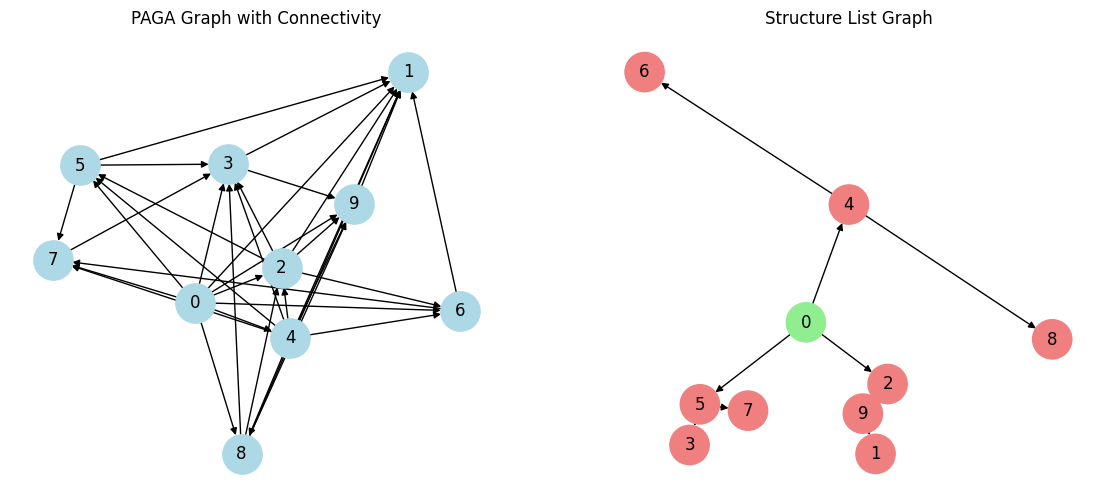

In [13]:
# 11. Execute Visualization
# =========================== #
visualize_combined_paga_and_structure(DG, structure_nodes, avg_time)

In [14]:
print("PAGA Edges:", DG.edges)

PAGA Edges: [('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('2', '1'), ('2', '3'), ('2', '5'), ('2', '6'), ('2', '9'), ('3', '1'), ('3', '9'), ('4', '1'), ('4', '2'), ('4', '3'), ('4', '5'), ('4', '6'), ('4', '7'), ('4', '8'), ('4', '9'), ('5', '1'), ('5', '3'), ('5', '7'), ('6', '1'), ('6', '7'), ('7', '3'), ('8', '1'), ('8', '2'), ('8', '3'), ('8', '9'), ('9', '1')]


In [15]:
structure_graph = nx.DiGraph()
for node in structure_nodes.values():  
    structure_graph.add_node(node['ID'])
    for child in node['child_path']:
        structure_graph.add_edge(node['ID'], child)

print("Structure List Edges:", structure_graph.edges)


Structure List Edges: [(0, 2), (0, 4), (0, 5), (2, 9), (4, 6), (4, 8), (5, 3), (5, 7), (9, 1)]


In [16]:
root = min(avg_time, key=avg_time.get)  
print(root)

0


In [17]:
paga_edges = set(DG.edges)
structure_edges = set(structure_graph.edges)

#extra edges in PAGA (PAGA edges that are missing in structure list)
extra_paga_edges = paga_edges - structure_edges
print("Extra edges in PAGA (not in structure list):", extra_paga_edges)

#  missing edges in PAGA (Structure list edges that are not in PAGA)
missing_paga_edges = structure_edges - paga_edges
print("Missing edges in PAGA (present in structure list):", missing_paga_edges)


Extra edges in PAGA (not in structure list): {('0', '4'), ('4', '9'), ('4', '3'), ('0', '1'), ('4', '7'), ('0', '5'), ('7', '3'), ('0', '6'), ('8', '1'), ('5', '3'), ('4', '1'), ('5', '7'), ('2', '9'), ('2', '3'), ('4', '6'), ('4', '5'), ('5', '1'), ('3', '9'), ('0', '2'), ('0', '8'), ('2', '1'), ('8', '2'), ('2', '6'), ('2', '5'), ('4', '2'), ('3', '1'), ('0', '9'), ('4', '8'), ('9', '1'), ('0', '3'), ('6', '7'), ('0', '7'), ('8', '9'), ('8', '3'), ('6', '1')}
Missing edges in PAGA (present in structure list): {(0, 4), (4, 6), (5, 7), (2, 9), (0, 2), (0, 5), (4, 8), (5, 3), (9, 1)}


=== Parent-Child Relationships ===
Node 0 -> Parent None
Node 1 -> Parent 9
Node 2 -> Parent 0
Node 3 -> Parent 5
Node 4 -> Parent 0
Node 5 -> Parent 0
Node 6 -> Parent 4
Node 7 -> Parent 5
Node 8 -> Parent 4
Node 9 -> Parent 2

=== DAG Visualization ===


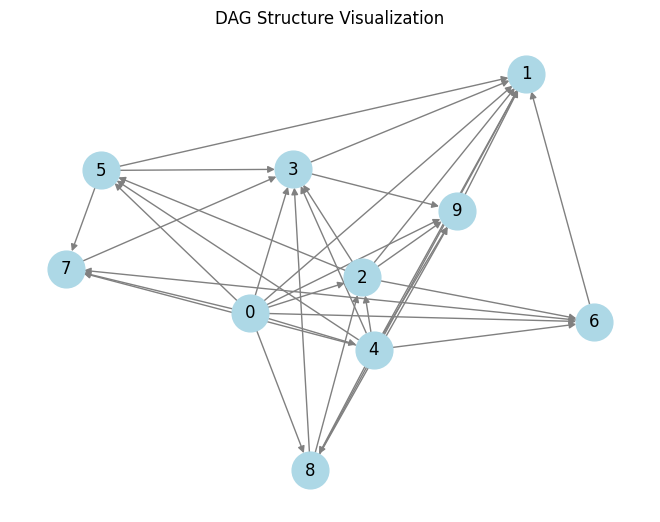


=== Checking for Disconnected Clusters ===

=== Checking Alpha Values for Each Node ===
Node 0 -> Alpha Mean: 0.0
Node 2 -> Alpha Mean: 0.0
Node 4 -> Alpha Mean: 0.0
Node 5 -> Alpha Mean: 0.0
Node 9 -> Alpha Mean: 0.0
Node 6 -> Alpha Mean: 0.0
Node 8 -> Alpha Mean: 0.0
Node 3 -> Alpha Mean: 0.0
Node 7 -> Alpha Mean: 0.0
Node 1 -> Alpha Mean: 0.0


In [18]:
print("=== Parent-Child Relationships ===")
for node, parent in parent_map.items():
    print(f"Node {node} -> Parent {parent}")

print("\n=== DAG Visualization ===")
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(DG, seed=42)
nx.draw(DG, pos, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray")
plt.title("DAG Structure Visualization")
plt.show()

print("\n=== Checking for Disconnected Clusters ===")
for cluster in DG.nodes:
    if cluster not in parent_map and cluster not in children_map:
        print(f"Warning: Cluster {cluster} is disconnected!")

print("\n=== Checking Alpha Values for Each Node ===")
for node in structure_list:
    print(f"Node {node['ID']} -> Alpha Mean: {np.mean(node['alpha'])}")


In [19]:
if nx.is_directed_acyclic_graph(DG):
    print("✅ The structure list forms a valid DAG.")
else:
    print("❌ Error: The structure list contains cycles!")


✅ The structure list forms a valid DAG.


In [ ]:
unique_structure_list = list({(node['Sp_idx'], node['Sc_idx']) for node in structure_list})
filtered_structure_list = [{'Sp_idx': sp, 'Sc_idx': sc} for sp, sc in unique_structure_list]

In [44]:
import numpy as np
from sklearn.linear_model import LassoCV
from joblib import Parallel, delayed
import time 

start_time = time.time()
# ------------------ Initialize Model -----------------------
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ------------------ Initialize Model -----------------------
def init_var_structure(structure_list, cell_names, cell_times, cell_exps, cell_labels, cell_path_init):
    """
    Initializes the CSHMM model with given structure and cell data.
    """
    n_cell, n_genes = cell_exps.shape
    
    unique_structure_list = list({(node['Sp_idx'], node['Sc_idx']) for node in structure_list})
    structure_list = [{'Sp_idx': sp, 'Sc_idx': sc} for sp, sc in unique_structure_list]

    
    max_index = max(max(node['Sp_idx'], node['Sc_idx']) for node in structure_list)
    n_state = max_index + 1  
    n_path = len(structure_list)  

   
    adj_mat = np.zeros((n_state, n_state))

    print("Checking structure_list before adjacency matrix initialization:")
    for node in structure_list:
        print(f"Parent {node['Sp_idx']} -> Child {node['Sc_idx']}")
        if node['Sp_idx'] >= n_state or node['Sc_idx'] >= n_state:
            print(f"Warning: Index out of bounds! Sp_idx={node['Sp_idx']}, Sc_idx={node['Sc_idx']}, n_state={n_state}")
        adj_mat[node['Sp_idx'], node['Sc_idx']] = 1  
    
    print("Adjacency Matrix after initialization:\n", adj_mat)

   
    g_param = np.zeros((n_state, n_genes))  
    sigma_param = np.ones(n_genes) 
    K_param = np.random.rand(n_path, n_genes) * 10 

    sp_indices = np.array([node['Sp_idx'] for node in structure_list])
    sc_indices = np.array([node['Sc_idx'] for node in structure_list])

    print("Sp Indices:", sp_indices)
    print("Sc Indices:", sc_indices)

    model = {
        'g_param': g_param,
        'sigma_param': sigma_param,
        'K_param': K_param,
        'trans_mat': adj_mat,
        'path_info': structure_list,
        'sp_indices': sp_indices,
        'sc_indices': sc_indices,
    }

    cell_time = np.random.rand(n_cell)
    hid_var = {
        'cell_time': cell_time,
        'cell_ori_time': cell_times,
        'cell_path': np.array(cell_path_init, dtype=int),
        'cell_labels': np.array(cell_labels)
    }

    optimize_w_nz(model, hid_var, cell_exps)
    model['path_trans_prob'] = compute_path_trans_log_prob(adj_mat, structure_list)

   
    plot_graph_from_adj_matrix(adj_mat)

    return model, hid_var


# ------------------ Helper Function to Plot Graph ------------------
def plot_graph_from_adj_matrix(adj_matrix):
    G = nx.DiGraph()
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] > 0:
                G.add_edge(i, j)

    plt.figure(figsize=(6, 4))
    nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", arrows=True)
    plt.title("Graph Representation of Adjacency Matrix")
    plt.show()



# ------------------ M-step Functions -----------------------
def optimize_g_param(model, hid_var, cell_exps, gene_names):
    """
    Optimizes g_param using Lasso regression.
    """
    print("M-step: optimizing g_param using Lasso (nonnegative)...")
    n_cell, n_gene = cell_exps.shape
    g_param = model['g_param']
    sigma_param = model['sigma_param']
    K_param = model['K_param']
    sp_indices = model['sp_indices']
    sc_indices = model['sc_indices']
    p_vec = hid_var['cell_path']
    t_vec = hid_var['cell_time']
    cell_idx = np.arange(n_cell)

    def _optimize_gene(j):
        """
        Optimizes gene parameters using Lasso regression.
        """
        A1 = np.zeros((n_cell, g_param.shape[0]))
        current_K = K_param[p_vec, j]
        w = np.exp(-current_K * t_vec)
        A1[cell_idx, sp_indices[p_vec]] = w
        A1[cell_idx, sc_indices[p_vec]] = 1 - w

        Xjs = np.asarray(cell_exps[:, j], dtype=float).flatten()

        lasso = LassoCV(alphas=np.logspace(-4, 2, 10), positive=True, fit_intercept=False, max_iter=10000, cv=5)
        lasso.fit(A1 / sigma_param[j], Xjs / sigma_param[j])

        return lasso.coef_

    results = Parallel(n_jobs=-1)(delayed(_optimize_gene)(j) for j in range(n_gene))
    for j, coef in enumerate(results):
        g_param[:, j] = coef
    model['g_param'] = np.maximum(g_param, 0)


def optimize_sigma_param(model, hid_var, cell_exps):
    """
    Optimizes sigma_param.
    """
    print("M-step: optimizing sigma_param...")
    n_cell, n_gene = cell_exps.shape
    K_param = model['K_param']
    g_param = model['g_param']
    sp_indices = model['sp_indices']
    sc_indices = model['sc_indices']
    p_vec = hid_var['cell_path']
    t_vec = hid_var['cell_time']

    mu_all = g_param[sc_indices[p_vec], :] + (g_param[sp_indices[p_vec], :] - g_param[sc_indices[p_vec], :]) * np.exp(-K_param[p_vec, :] * t_vec[:, None])
    diff_sq = np.square(cell_exps - mu_all)
    sigma_param = np.sqrt(np.sum(diff_sq, axis=0) / n_cell)
    sigma_param[sigma_param < 1] = 1
    model['sigma_param'] = sigma_param


def optimize_w_nz(model, hid_var, cell_exps):
    """
    Optimizes dropout weights.
    """
    print("M-step: optimizing dropout weights (w_nz)...")
    n_path, n_gene = model['K_param'].shape
    model['w_nz'] = np.ones((n_path, n_gene))


# ------------------ E-step -----------------------
def assign_path_and_time(model, hid_var, cell_exps):
    """
    Assigns new paths and times to cells using vectorized operations.
    """
    print("E-step: Assigning new path and time for cells (Vectorized)...")

    n_cell, n_gene = cell_exps.shape
    n_path = model['K_param'].shape[0]
    candidate_times = np.linspace(0, 1, 100)  # (100,)

    # Reshape candidate_times for broadcasting
    candidate_times_exp = candidate_times[:, None, None]  # Shape: (100, 1, 1)

    # Extract model parameters for parent and child states
    g_sp = model['g_param'][model['sp_indices']]  # Shape: (n_path, n_gene)
    g_sc = model['g_param'][model['sc_indices']]  # Shape: (n_path, n_gene)
    K_p = model['K_param']  # Shape: (n_path, n_gene)

    # Expand dimensions to align shapes correctly
    g_sp = g_sp[None, :, :]  # Shape: (1, n_path, n_gene)
    g_sc = g_sc[None, :, :]  # Shape: (1, n_path, n_gene)
    K_p = K_p[None, :, :]  # Shape: (1, n_path, n_gene)
    candidate_times_exp = np.broadcast_to(candidate_times_exp, (100, n_path, n_gene))  # Shape: (100, n_path, n_gene)

    # Compute decay factor correctly
    decay_factor = np.exp(-K_p * candidate_times_exp)  # Shape: (100, n_path, n_gene)

    # Compute mean expression (`mu_candidates`)
    mu_candidates = g_sc + (g_sp - g_sc) * decay_factor  # Shape: (100, n_path, n_gene)

    # Fix shape mismatch issue
    mu_candidates = np.transpose(mu_candidates, (1, 0, 2))  # Shape: (n_path, 100, n_gene)

    # Expand cell expressions for broadcasting
    cell_exps_exp = cell_exps[:, None, None, :]  # Shape: (n_cell, 1, 1, n_gene)

    # Compute log probabilities (Fix shape alignment)
    log_probs = -np.sum((cell_exps_exp - mu_candidates[None, :, :, :]) ** 2, axis=-1)  # Shape: (n_cell, n_path, 100)

    # Find best path and time for each cell
    best_idx = np.argmax(log_probs, axis=-1)  # Shape: (n_cell, n_path)
    best_log_probs = np.max(log_probs, axis=-1)  # Shape: (n_cell, n_path)

    # Get best path per cell
    new_cell_paths = np.argmax(best_log_probs, axis=-1)  # Shape: (n_cell,)
    new_cell_times = candidate_times[best_idx[np.arange(n_cell), new_cell_paths]]  # Shape: (n_cell,)

    # Store updated values
    hid_var['cell_path'] = new_cell_paths
    hid_var['cell_time'] = new_cell_times




def compute_path_trans_log_prob(trans_mat, path_info, epsilon=1e-10):
    """
    Computes transition log probabilities.
    """
    ret = []
    for node in path_info:
        mult = 1
        for parent_id in node.get('parent_path', []):
            parent_node = next((n for n in path_info if n['ID'] == parent_id), None)
            if parent_node:
                mult *= trans_mat[parent_node['Sc_idx'], node['Sp_idx']]
        ret.append(np.log(mult + epsilon))
    return np.array(ret)


# ------------------ Core Fitting Loop -----------------------
def optimize_likelihood(cell_exps, gene_names, model, hid_var, n_iteration=10, tolerance=1e-4):
    """
    Optimizes the model likelihood.
    """
    prev_ll = -np.inf
    for it in range(n_iteration):
        print(f"\nTraining iteration: {it + 1}")
        assign_path_and_time(model, hid_var, cell_exps)
        optimize_g_param(model, hid_var, cell_exps, gene_names)
        optimize_sigma_param(model, hid_var, cell_exps)
        optimize_w_nz(model, hid_var, cell_exps)

        ll = np.sum(np.log(np.maximum(1e-10, hid_var['cell_time'])))
        print(f"Log-likelihood: {ll:.4f}")

        if np.abs(ll - prev_ll) < tolerance:
            print("Convergence reached.")
            break
        prev_ll = ll
    end_time = time.time()
    print(f"\nTotal runtime for modeling: {end_time - start_time:.2f} seconds")

Checking structure_list before adjacency matrix initialization:
Parent 0 -> Child 1
Parent 1 -> Child 2
Parent 2 -> Child 3
Parent 3 -> Child 4
Adjacency Matrix after initialization:
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]
Sp Indices: [0 1 2 3]
Sc Indices: [1 2 3 4]
M-step: optimizing dropout weights (w_nz)...


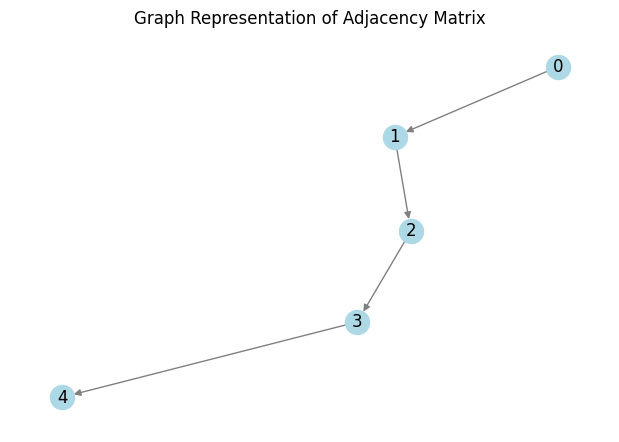

CSHMM model initialized successfully.
Starting CSHMM training (10 iterations)...

Training iteration: 1
E-step: Assigning new path and time for cells (Vectorized)...
M-step: optimizing g_param using Lasso (nonnegative)...
M-step: optimizing sigma_param...
M-step: optimizing dropout weights (w_nz)...
Log-likelihood: -125582.9910

Total runtime for modeling: 10.34 seconds
CSHMM training complete!


In [45]:
# Extract necessary variables from AnnData
cell_names = adata.obs_names.tolist()
cell_times = adata.obs['days_num'].values
cell_exps = adata.X.toarray() if hasattr(adata.X, "toarray") else np.array(adata.X)
cell_labels = adata.obs['leiden'].values
cell_path_init = [int(cl) for cl in adata.obs['leiden']]

model, hid_var = init_var_structure(
    structure_list, cell_names, cell_times, cell_exps, cell_labels, cell_path_init
)

print("CSHMM model initialized successfully.")
print("Starting CSHMM training (10 iterations)...")

optimize_likelihood(
    cell_exps,
    adata.var_names.tolist(),
    model,
    hid_var,
    n_iteration=1
)

print("CSHMM training complete!")



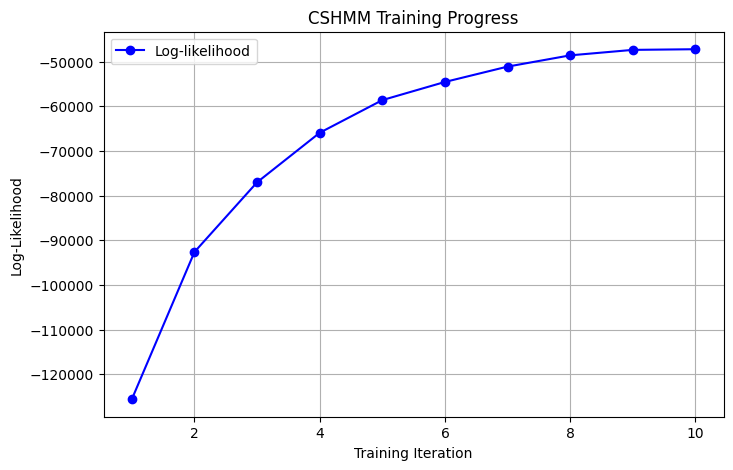

In [46]:
import matplotlib.pyplot as plt

iterations = list(range(1, 11))
log_likelihoods = [-125582.9910, -92616.0240, -77006.6400, -65916.5044, 
                   -58604.4929, -54540.2553, -51102.1308, -48582.8163, 
                   -47357.8242, -47211.4114]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, log_likelihoods, marker='o', linestyle='-', color='b', label='Log-likelihood')

# Labels and title
plt.xlabel('Training Iteration')
plt.ylabel('Log-Likelihood')
plt.title('CSHMM Training Progress')
plt.grid(True)
plt.legend()
plt.show()


In [22]:
print("Full Transition Matrix (Adjacency):")
print(model['trans_mat'])


Full Transition Matrix (Adjacency):
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [33]:
print("Structure List (Input to Model):", structure_list)


Structure List (Input to Model): [{'ID': 0, 'Sp_idx': 0, 'Sc_idx': 1, 'level': 0, 'alpha': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.

NameError: name 'adj_mat' is not defined

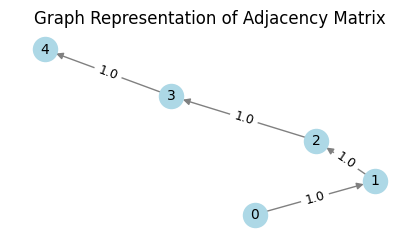

In [39]:
import networkx as nx

def plot_graph(adj_matrix):
    G = nx.DiGraph()
    num_nodes = adj_matrix.shape[0]

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i, j] > 0:  # Add edge only if there's a connection
                G.add_edge(i, j, weight=adj_matrix[i, j])

    plt.figure(figsize=(4,2))
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", arrows=True, font_size=10)
    
    # Draw edge labels (weights)
    edge_labels = {(i, j): f"{adj_matrix[i, j]:.1f}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Graph Representation of Adjacency Matrix")
    plt.show()

# Call the function
plot_graph(model['trans_mat'])


In [35]:
print("Structure List:")
for node in structure_list:
    print(f"Parent {node['Sp_idx']} -> Child {node['Sc_idx']}")


Structure List:
Parent 0 -> Child 1
Parent 1 -> Child 2
Parent 1 -> Child 2
Parent 1 -> Child 2
Parent 2 -> Child 3
Parent 2 -> Child 3
Parent 2 -> Child 3
Parent 2 -> Child 3
Parent 2 -> Child 3
Parent 3 -> Child 4


In [36]:
print("Adjacency Matrix (Used by Model):")
print(model['trans_mat'])


Adjacency Matrix (Used by Model):
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [23]:
print("Assigned Paths for Cells:")
print(hid_var['cell_path'])

Assigned Paths for Cells:
[0 0 0 ... 6 8 9]


In [24]:
print("Computed Log Transition Probabilities:")
print(model['path_trans_prob'])

Computed Log Transition Probabilities:
[ 1.00000008e-10 -2.30258509e+01 -2.30258509e+01 -2.30258509e+01
 -2.30258509e+01 -2.30258509e+01 -2.30258509e+01 -2.30258509e+01
 -2.30258509e+01 -2.30258509e+01]


In [25]:
for i, node in enumerate(structure_list):
    print(f"Node {i}: Sp_idx={node['Sp_idx']}, Sc_idx={node['Sc_idx']}")

Node 0: Sp_idx=0, Sc_idx=1
Node 1: Sp_idx=1, Sc_idx=2
Node 2: Sp_idx=1, Sc_idx=2
Node 3: Sp_idx=1, Sc_idx=2
Node 4: Sp_idx=2, Sc_idx=3
Node 5: Sp_idx=2, Sc_idx=3
Node 6: Sp_idx=2, Sc_idx=3
Node 7: Sp_idx=2, Sc_idx=3
Node 8: Sp_idx=2, Sc_idx=3
Node 9: Sp_idx=3, Sc_idx=4


In [26]:
disconnected_states = np.where(np.sum(model['trans_mat'], axis=1) == 0)[0]
print("Disconnected States:", disconnected_states)

Disconnected States: [ 4  5  6  7  8  9 10]


In [27]:
all_states = set()
for node in structure_list:
    all_states.add(node['Sp_idx'])
    all_states.add(node['Sc_idx'])

print("Unique states in transitions:", sorted(all_states))

Unique states in transitions: [0, 1, 2, 3, 4]


Plotting CSHMM structure...
Structure graph saved as structure.png


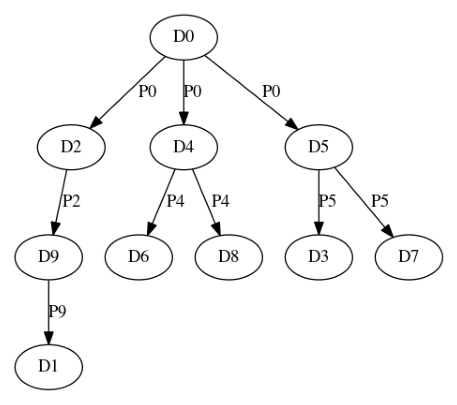

In [28]:
import pygraphviz as pgv
import matplotlib.pyplot as plt
import networkx as nx

def plot_structure_graph(structure_list, output_file="structure.png"):
    """
    Plots the CSHMM structure as a directed acyclic graph (DAG).
    
    Args:
        structure_list (list): List of dictionaries representing structure nodes.
        output_file (str): Filename to save the graph.
    """
    print("Plotting CSHMM structure...")

   
    G = pgv.AGraph(directed=True, strict=True)

    for node in structure_list:
        node_id = f"D{node['ID']}"
        G.add_node(node_id, shape="ellipse")  # Nodes as ellipses

        for child in node['child_path']:
            child_id = f"D{child}"
            G.add_edge(node_id, child_id, label=f"P{node['ID']}")


    G.graph_attr.update(rankdir="TB", splines="true")  # "TB" for top-down, "LR" for left-right

  
    G.layout(prog='dot')
    G.draw(output_file)
    
    print(f"Structure graph saved as {output_file}")

    
    img = plt.imread(output_file)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


plot_structure_graph(structure_list)


Plotting CSHMM structure...
Structure graph saved as structure.png


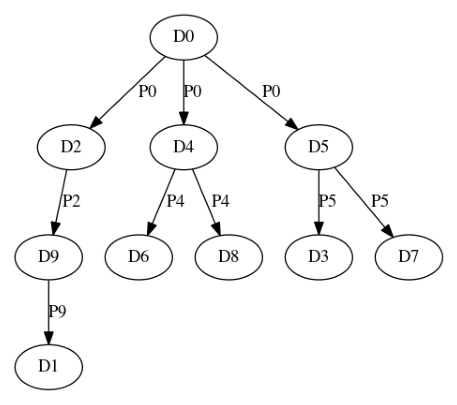

In [29]:
plot_structure_graph(structure_list)